<a href="https://colab.research.google.com/github/aibijq/skku_gsb/blob/main/%EA%B3%BC%EC%A0%9C_%ED%8F%AC%ED%8A%B8%ED%8F%B4%EB%A6%AC%EC%98%A4%EC%B5%9C%EC%A0%81%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 개요.포트폴리오 시나리오
---
##### case1.배당주
    - 프로필 : 60대 은퇴자(각 기업/산업을 고려 하지 않고 배당이 높은 기업들만 모은 포트폴리오. 위험중립형)
    - Theme : TIGER 미국 나스닥 커버드(합성)(441680.KS), TIGER 미국배당 +7%프리미엄 다우존(458760.KS), TIGER 배당프리미엄액티(472150.KS), ACE 미국배당 다우존(402970.KS), KODEX 미국배당프리미엄액티브(441640.KS), SOL 미국배당다우존(446720.KS), KBSTAR 미국 S&P 배당킹(460660.KS), WOORI200(448100.KS)

##### case2.한국/미국 대표지수
    Theme : KODEX 200(069500.KS), TIGET200(102110.KS), KBSTAR200(148020.KS), ARIRANG200(152100.KS), KINDEX200(105190.KS), KOSEF200(069660.KS), HANARO200(293180.KS), KBSTAR 미국 S&P 500(379780.KS)
    프로필 : 50대 직장인(오랜기간 업계를 리딩하는 기업들을 모은 포트폴리오. 안정추구형)
##### case3.ETF 시가총액 Top 8
    Theme : SPY, IVV, VOO, VTI, QQQ, VEA, VUG, VTV
    프로필 : 40대 직장인(최근 수년간 급 성장한 기업을 위주로 투자하는 포트폴리오. 적극투자형)
##### case4.중위험
    Theme : KODEX 200 (069500.KS), KODEX 종합채권(AA-이상)액티브 (261240), TIGER KRX바이오 K-뉴딜 (329200.KS), KBSTAR 중소형고배당 (266160.KS), TIGER 200 IT (157490.KS), KODEX 미디어&엔터테인먼트 (266360.KS), KODEX 선진국MSCI World (251350.KS), KBSTAR 단기국공채액티브 (252670.KS)
    프로필 : 30대 직장인(안정적이고 높은 수익률을 원하는 30대를 위해 중위험 종목으로만 구성한 포트폴리오. 적극투자형)
##### case5.레버리지
    Theme : 코스닥 150레버리지(233740.KS), KBSTAR 코스닥150 선물레버리지(278240.KS), KODEX200 선물레버리(252670.KS), KRX300레버리지(253280.KS), KODEX 레버리지(122630.KS), TIGER레버리지(123320.KS), 유로스탁50 선물(261240.KS), KBSATR 200선물인버스 2X(252710.KS)
    프로필 : 20대 직장인(자산형성 초기 단계로 위험을 감수할 수 있는 20대를 위해 폭발적인 급등이 가능한 종목으로 구성한 포트폴리오, 공격투자형)

### step0. 환경설정(Google colab)

In [ ]:
!pip install yfinance
!pip install plotly
!pip install cvxpy # optimizer
!pip install PyPortfolioOpt
!pip install plotly
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.4 MB/s eta 0:00:00


In [38]:
import yfinance as yf
import pandas as pd
import numpy as np
import pypfopt as ppf

from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt import black_litterman, BlackLittermanModel

import seaborn as sns
import matplotlib.pyplot as plt

### step1. fetch_stock_data

In [39]:
def fetch_stock_data(tickers, start_date, end_date):
    stock_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return stock_data

In [40]:
tickers_list = [
    ["441680.KS", "458760.KS", "472150.KS", "402970.KS", "441640.KS","446720.KS","460660.KS","448100.KS"],
    ["069500.KS", "102110.KS", "148020.KS", "152100.KS", "105190.KS","069660.KS","293180.KS","379780.KS"],
    ["SPY", "IVV", "VOO", "VTI", "QQQ","VEA","VUG","VTV"],
    ["069500.KS", "261240.KS", "329200.KS", "266160.KS", "157490.KS", "266360.KS", "251350.KS", "252670.KS"],
    ["233740.KS", "278240.KS", "252670.KS", "253280.KS", "122630.KS","123320.KS","261240.KS","252710.KS"]
]

start_date = "2019-01-01"
end_date = "2024-01-01"

stock_data_list = []
for tickers in tickers_list:
    stock_data = fetch_stock_data(tickers, start_date, end_date)
    stock_data_list.append(stock_data)

Case1_stock, Case2_stock, Case3_stock, Case4_stock, Case5_stock = stock_data_list

market_data = fetch_stock_data("SPY", start_date, end_date).to_frame() # SPY : (S&P 500 ETF)의 주가 데이터

[*********************100%%**********************]  8 of 8 completed
[*********************100%%**********************]  8 of 8 completed
[*********************100%%**********************]  8 of 8 completed
[*********************100%%**********************]  8 of 8 completed
[*********************100%%**********************]  8 of 8 completed
[*********************100%%**********************]  1 of 1 completed


### step2. 전처리
1. filled_dataframes = NaN 값을 중간값으로 대체
2. cleaned_dataframes = NaN 값을 제거 (NaN을 포함하는 행을 삭제)

In [69]:
stock_dataframes = [Case1_stock, Case2_stock, Case3_stock, Case4_stock, Case5_stock]
#1.
filled_dataframes = [df.fillna(df.median()) for df in stock_dataframes]
#2.
cleaned_dataframes = [df.fillna(df.dropna()) for df in stock_dataframes]
Case1_stock_filled, Case2_stock_filled, Case3_stock_filled, Case4_stock_filled, Case5_stock_filled = filled_dataframes[:5]
Case1_stock_cleaned,Case2_stock_cleaned,Case3_stock_cleaned,Case4_stock_cleaned,Case5_stock_cleaned = cleaned_dataframes[:5]

In [70]:
# 각 데이터프레임에 대해 컬럼 이름을 변경합니다.
Case1_stock_filled = Case1_stock_filled.rename(columns={
    "441680.KS": "Nasdaq100_ETF",
    "458760.KS": "7%_Premium_ETF",
    "472150.KS": "Mirae_Asset_ETF",
    "402970.KS": "KINDEX_S&P_100_ETF",
    "441640.KS": "Samsung_Kodex_ETF",
    "446720.KS": "Shinhan_Sol_ETF",
    "460660.KS": "KB_Kbstar_ETF",
    "448100.KS": "Woori_Ks200_ETF"
})

Case2_stock_filled = Case2_stock_filled.rename(columns={
    "069500.KS": "KODEX_200",
    "102110.KS": "MiraeAsset_200_ETF",
    "148020.KS": "KStar200_ETF",
    "152100.KS": "Arirang200_ETF",
    "105190.KS": "KIMC_KINDEX200",
    "069660.KS": "KOSEF200",
    "293180.KS": "NHAmundi_HANARO200_ETF",
    "379780.KS": "KbStarSnP500_ETF"
})

### step3. CAMP모형적용 (Mu, Sigma)

* CAPM(Capital Asset Pricing Model)을 기반으로 주식의 예상 수익률을 계산
    * Ri = Rf + bi * (Rm - Rf)
    * Ri: 자산이나 포트폴리오의 예상 수익률
    * Rf: 무위험 이자율 (Risk-Free Rate) - 어떤 투자에서도 발생하지 않는, 안전하게 얻을 수 있는 수익
    * bi: 자산이나 포트폴리오의 beta 값 (시장 위험에 대한 민감도) - beta 값은 시장과의 상관관계를 나타냄
    * Beta가 1이면 자산의 수익률은 시장과 동일하게 움직이며, Beta가 0이면 시장과 상관관계가 없다
    * Rm: 시장 수익률 - 주식 시장 전체의 예상 수익률
* Ledoit-Wolf 방법을 통해 공분산 행렬을 계산
    * 기존의 주가 데이터를 기반으로 한 공분산 행렬의 추정에 사용되는 방법 중 하나입니다. 주식 데이터로부터 계산된 표본 공분산 행렬은 표본 크기가 작은 경우 불안정
    * Ledoit_wolf_single_factor - 단일 요인 모델을 사용하여 공분산 행렬을 추정
    * Ledoit-Wolf 방법은 다중 요인 모델을 사용

In [81]:
for pricesCase in stock_dataframes:
    # CAPM 모델을 기반으로 예상 수익률을 계산
    mu = expected_returns.capm_return(prices=pricesCase, market_prices=market_data, risk_free_rate=0.05)
    # Ledoit-Wolf 단일 요인 모델을 사용하여 공분산 행렬을 추정
    Sigma = risk_models.risk_matrix(pricesCase, method="ledoit_wolf")
    corr_mat = risk_models.cov_to_corr(Sigma) # 공분산 행렬을 상관 행렬로 변환
    # EfficientFrontier 생성
    ef = EfficientFrontier(mu, Sigma)
    # 최소 변동성 설정
    ef.min_volatility()
    # 최소 변동성 포트폴리오의 수익률, 변동성 및 샤프 비율 확인
    min_volatility_return, min_volatility_volatility, min_volatility_sharpe = ef.portfolio_performance()
    # # 공분산 행렬 그래프를 그립니다.
    # plotting.plot_covariance(Sigma)
    # plt.title('Covariance Matrix')
    # plt.show()

    # # 상관 행렬 그래프를 그립니다.
    # sns.heatmap(corr_mat, annot=True, cmap='coolwarm')
    # plt.title('Correlation Matrix')
    # plt.show()
    # EfficientFrontier 시각화
    # fig, ax = plt.subplots()
    # plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
    # plt.show()

/usr/local/lib/python3.10/dist-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(


InstantiationError: Adding constraints to an already solved problem might have unintended consequences. A new instance should be created for the new set of constraints.

### step4. 포트폴리오 최적화

In [55]:
# 포트폴리오의 변동성 대비 예상 수익률을 계산
lst = []         # 효율적인 포트폴리오의 가중치를 저장할 리스트
vollist = []     # 변동성 목표값을 저장할 리스트
riskreturn = []  # 각 포트폴리오의 변동성 및 예상 수익률을 저장할 리스트

# min_volatility_volatility보다 +1씩 증가하여 10번 수행
lr_start = round(min_volatility_volatility*100)
lr_end = round(min_volatility_volatility*100) + 11
print(lr_start, lr_end)

for i in range(lr_start,lr_end):
    volatility_target = i/100
    mu = expected_returns.capm_return(prices=Case2_stock_filled, market_prices=market_data, returns_data=False)
    Sigma = risk_models.risk_matrix(Case2_stock_filled, method="ledoit_wolf_single_factor", returns_data=False)

    #weight bound <0.75 (왜?)
    ef = EfficientFrontier(mu, Sigma, weight_bounds=(0.0, 0.75))
    raw_weights = ef.efficient_risk(volatility_target)
    lst.append(ef.clean_weights())
    vollist.append('{:.1f}%'.format(volatility_target*100))
    riskreturn.append(ef.portfolio_performance())

12 23


/usr/local/lib/python3.10/dist-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pypfopt/expected_returns.py:32: User

### step5. 시각화

In [56]:
#포트폴리오 가중치 생성
assetnames = ("Nasdaq100_ETF", "7%_Premium_ETF", "Mirae_Asset_ETF", "KINDEX_S&P_100_ETF", "Samsung_Kodex_ETF", "Shinhan_Sol_ETF", "KB_Kbstar_ETF", "Woori_Ks200_ETF")
assetnames = ("KODEX_200", "MiraeAsset_200_ETF", "KStar200_ETF", "Arirang200_ETF", "KIMC_KINDEX200", "KOSEF200", "NHAmundi_HANARO200_ETF", "KbStarSnP500_ETF")

data = [list(d.values()) for d in lst]
weights_table = pd.DataFrame(data, columns=assetnames)
weights_table.index = vollist
riskreturn_table = pd.DataFrame(riskreturn, columns=["Portfolio Return", "Portfolio Volatility", "Sharpe Ratio"])

<Axes: >

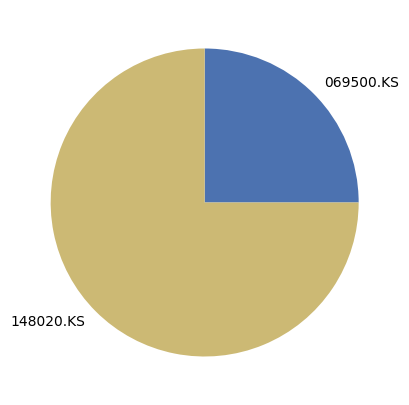

In [57]:
pd.Series(ef.clean_weights()).plot.pie(figsize=(5,5)) # BL에서 추가

<Axes: >

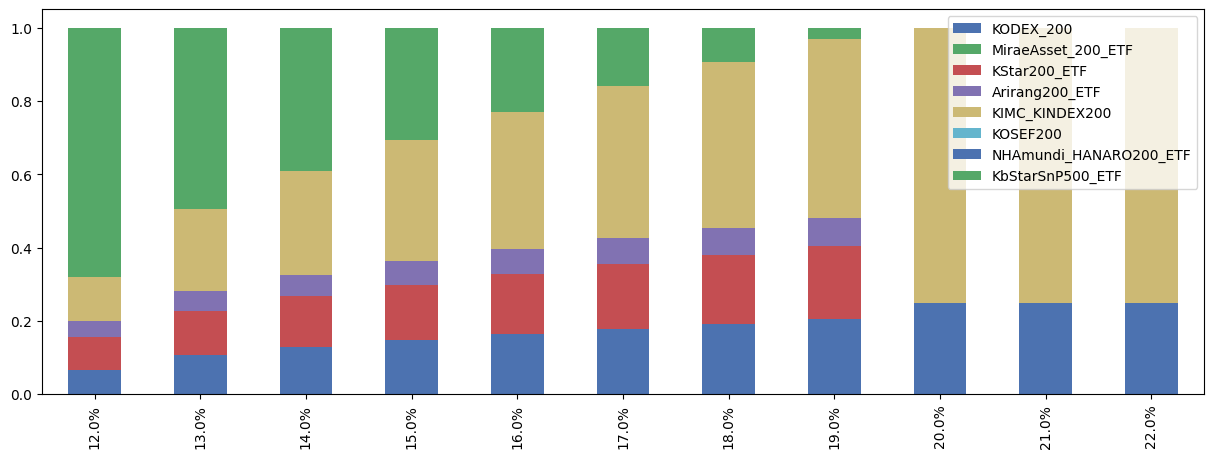

In [62]:
# pd.Series(ef.clean_weights()).plot.pie(figsize=(5,5)) # BL에서 추가
weights_table.plot.bar(stacked=True, figsize=(15,5))

array([<Axes: title={'center': 'KODEX_200'}>,
       <Axes: title={'center': 'MiraeAsset_200_ETF'}>,
       <Axes: title={'center': 'KStar200_ETF'}>,
       <Axes: title={'center': 'Arirang200_ETF'}>,
       <Axes: title={'center': 'KIMC_KINDEX200'}>,
       <Axes: title={'center': 'KOSEF200'}>,
       <Axes: title={'center': 'NHAmundi_HANARO200_ETF'}>,
       <Axes: title={'center': 'KbStarSnP500_ETF'}>], dtype=object)

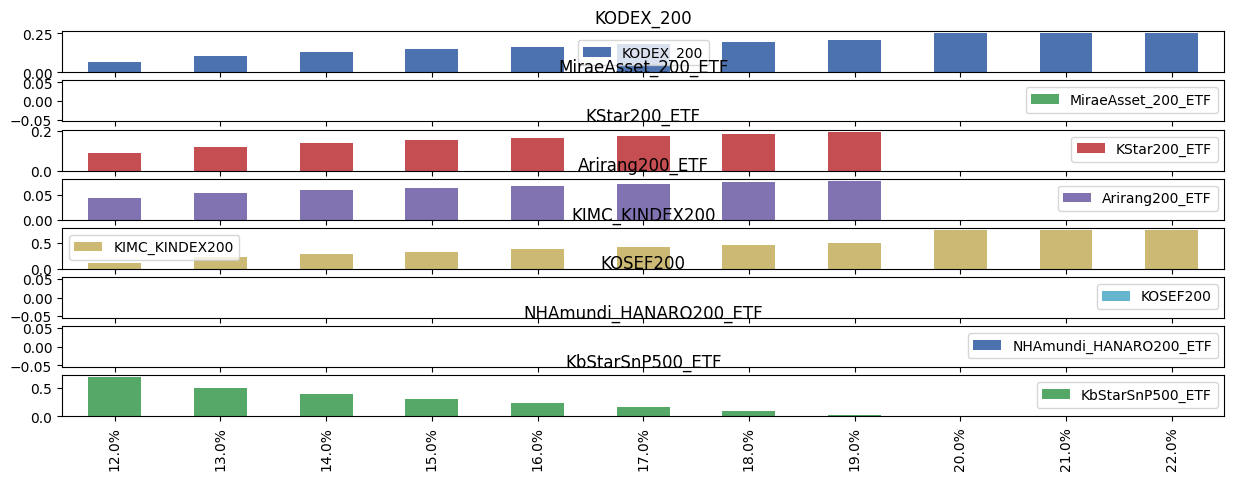

In [ ]:
weights_table.plot.bar(stacked=True, figsize=(15,5), subplots=True)

<Axes: xlabel='Portfolio Volatility', ylabel='Portfolio Return'>

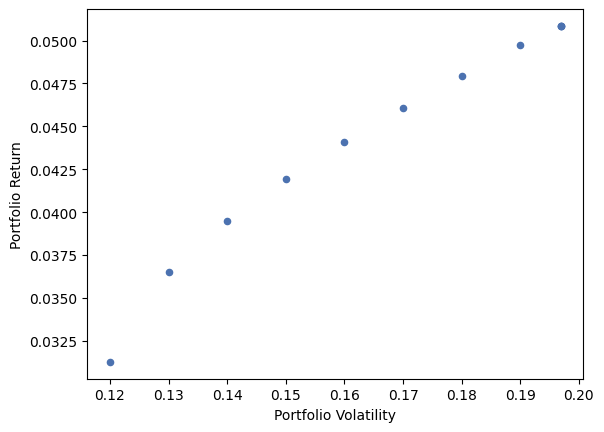

In [ ]:
riskreturn_table.plot.scatter("Portfolio Volatility", "Portfolio Return")

### step6.시뮬레이션 (고/중/저위험)

In [ ]:
return_table = Case2_stock_filled.pct_change().dropna()

cumret_table = pd.DataFrame()
portret_table = pd.DataFrame()

def plot_cumret(weights, return_table, portname):
    portret_table[portname] = return_table.dot(weights)
    cumret_table[portname] = (1 + portret_table[portname]).cumprod()

# weights를 NumPy 배열로 변환
weights_1 = weights_table.loc["12.0%"].values
weights_2 = weights_table.loc["17.0%"].values
weights_3 = weights_table.loc["22.0%"].values

plot_cumret(weights_1, return_table, portname = "Low Risk")
plot_cumret(weights_2, return_table, portname = "Mid Risk")
plot_cumret(weights_3, return_table, portname = "High Risk")

# plot_cumret(weights_table.loc["12.0%"], return_table, portname = "Low Risk")
# plot_cumret(weights_table.loc["17.0%"], return_table, portname = "Mid Risk")
# plot_cumret(weights_table.loc["22.0%"], return_table, portname = "High Risk")

<Axes: xlabel='Date'>

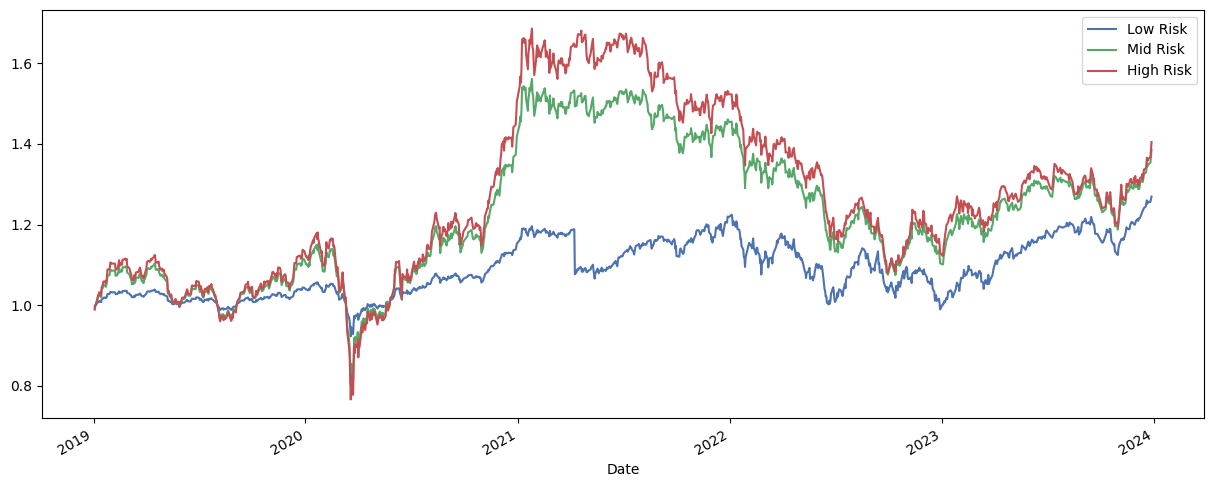

In [ ]:
cumret_table.plot(figsize=(15,6))

In [ ]:
portret_table.std()*np.sqrt(252)

Low Risk     0.119982
Mid Risk     0.173098
High Risk    0.199373
dtype: float64